#航空宇宙情報システム学第二： 6月13日課題 (HW2023-04)


前回の授業で使った「都道府県別家計支出データ」を題材にして以下の課題に取り組んでください。

**(1)** まず、81次元の変数を全て使って、$k$-means法で47都道府県をクラスタリングしてください。$k$の数はまず$2$から始めて、$3,4,\ldots,5$と増やして、誤差平方和(SSE,distortion)の変化をみてください。
**(注意)** 授業で説明したように、$k$-means法は初期解に依存して局小解に陥ることが
あります。

**(2)** 一般に$k$-means法は高次元データを苦手とすることが知られています。そこで、前回扱った主成分分析(PCA)で81次元を適当な次元まで削減した上で、$k$-means法によるクラスタリングを行なってみてください。

もし余裕があれば、PCAで削減した次元で色別の散布図を描くなどして、結果を可視化してみてください（必須ではありません）。


ファイル名は、HW2023-04.ipynb のまま提出して構いません。

提出期限は、3週間後の7月4日8時30分 (次々回授業の直前) とします。

_____

#(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ee9066f22551d2b95189f3073f8d79a013dd343bb30c0b347fe9be270cdd23ce
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
# データを読み込み、訓練、テストデータを作成

df = pd.read_csv('/content/drive/My Drive/都道府県別支出統計細目2019.csv',skiprows=1,index_col=0)
X = (df-df.mean()).values

In [ ]:
# 点群Xと点群Yの各点間の二乗距離を求める関数
def sqdist(X,Y):
  D = np.sum(X**2,axis=1).reshape((-1,1)) + np.sum(Y**2,axis=1).reshape((1,-1)) - 2*np.dot(X,Y.T)
  return D

In [ ]:
### k-means 法によるクラスタリング (素朴な初期化)
def kmeans(X,K=2):
  # データサンプル数
  n = X.shape[0]
  # クラスター代表点の選定 (データサンプルからランダムに選ぶ)
  ix = np.random.choice(n,K,replace=False)
  C = X[ix,:]
  # 繰り返しの最高回数(本来はこれも引数で設定するのが好ましい)
  itermax = 100
  # 繰り返し
  for iter in range(itermax):
    # print("Iteration:",iter)
    # 二乗距離を計算
    D = sqdist(X,C)
    # 一番近いクラスターに割当
    asgn = np.argmin(D,axis=1)
    # クラスター代表を更新
    for k in range(K):
      C[k,:] = np.mean(X[asgn==k,:],axis=0)
    # SSEを計算
    sse = np.sum((X - C[asgn,:])**2)
    # print("SSE=",sse)
    # 収束判定
    if iter >= 1:
      if sse_pre - sse < 1.0e-6:
        break
    sse_pre = sse
  return C,asgn,sse


In [ ]:
C,asgn,sse = kmeans(X,2)

In [ ]:
sselst = []
for i in range(2,7):
  sselst.append(kmeans(X,i)[2])

In [ ]:
sselst

[4175228864.2948723,
 4011637000.7838917,
 3169589550.6428566,
 3050594882.972727,
 2943030758.4047623]

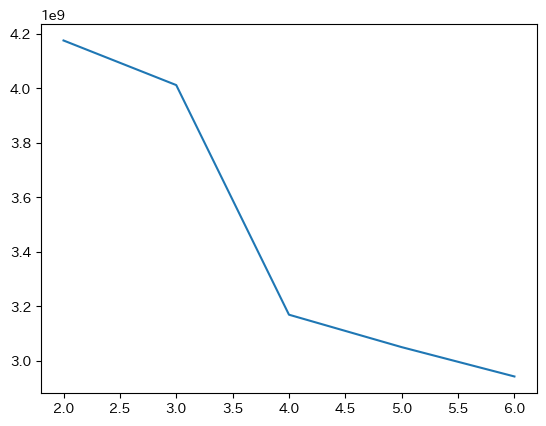

In [ ]:
plt.plot(list(range(2,7)),sselst)

#(2)

In [ ]:
C,asgn,sse = kmeans(X,7)

In [ ]:
# 共分散行列
Cpref = (1/len(X))*np.dot(X.T,X)
# 共分散行列のrank
print("rank of Cpref",la.matrix_rank(Cpref))
# 固有値固有ベクトル
lmdp,Vp = la.eigh(Cpref)
# 大きい順(降順)に並び替え
lmdp = lmdp[::-1]
Vp = Vp[:,::-1]

rank of Cpref 46


In [ ]:
# 第8主成分まで、座標（主成分得点）を求める
Up = np.dot(X,Vp[:,:8])

In [ ]:
numbercolor=["b","g","r","c","m","y","k","w"]

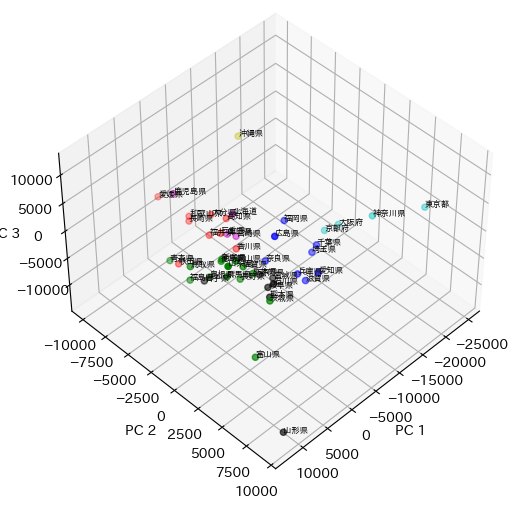

In [ ]:
prefs = df.index
colors=[]
for i in asgn:
    colors.append(numbercolor[i])

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection='3d')

ax.scatter(Up[:,0],Up[:,1],Up[:,2],color=colors)

for i in range(len(Up[:,0])):
  ax.text(Up[i,0],Up[i,1],Up[i,2],prefs[i],fontsize=6)


ax.view_init(45,45)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()

sklearnの中にある主成分分析のメソッドを用いる

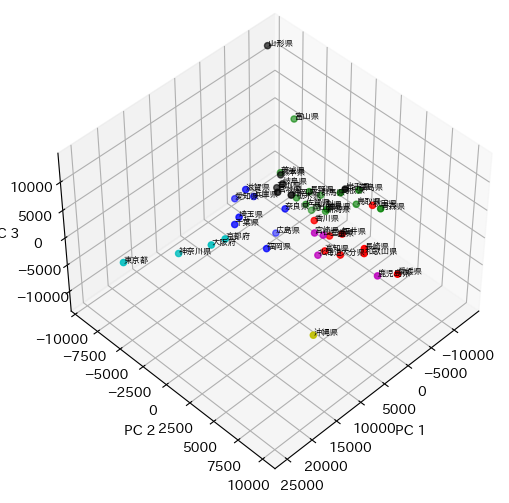

In [ ]:
colors=[]
for i in asgn:
    colors.append(numbercolor[i])

pca=decomposition.PCA(n_components=3)
feature3=pca.fit_transform(X)


df_3=pd.DataFrame(feature3)

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection='3d')

ax.scatter(df_3[0],df_3[1],df_3[2],color=colors)

for i in range(len(Up[:,0])):
  ax.text(df_3[0][i],df_3[1][i],df_3[2][i],prefs[i],fontsize=6)

ax.view_init(45,45)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.show()